In [85]:
# Basic set-ups 
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [86]:
# import data 
data = pd.read_csv("./apple.tsv", sep='\t',header=None, usecols=[0])

In [87]:
content_list = data[0].to_list()
# data cleaning for wired char \\n\\
data_c = [d.replace("\\n\\", " ") for d in content_list]

In [88]:
data_after_simple_preprocess = [gensim.utils.simple_preprocess(d, deacc=True) for d in data_c]

In [89]:
# combine bigram and trigram together 
bigram = gensim.models.Phrases(data_after_simple_preprocess, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_after_simple_preprocess], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [90]:
# slow one
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
data_no_stop = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in data_after_simple_preprocess]

In [91]:
# helper functions geted from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [92]:
data_words_bigrams = make_bigrams(data_no_stop)
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [93]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
#  Frequency
corpus = [id2word.doc2bow(text) for text in texts]

first loop thourgh 10 to 60 topics by stepsize of 10 to get na idea where might be the best score 

In [94]:
#*** modeling ***
result_cs = []
# first loop thourgh 10 to 50 topics by stepsize of 10 to get na idea where might be the best score 
for it in range(1,6):
    i = it *10 
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(str(i)+" topics",'\nCoherence Score: ', coherence_lda)
    result_cs.append(coherence_lda)

10 topics 
Coherence Score:  0.43487446981698685
20 topics 
Coherence Score:  0.4420223542181311
30 topics 
Coherence Score:  0.44133798832659504
40 topics 
Coherence Score:  0.4058080413680726
50 topics 
Coherence Score:  0.39578487391248424


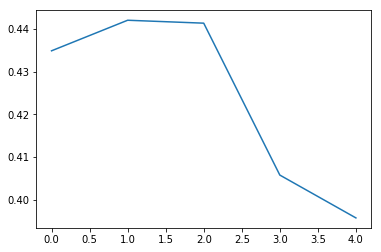

In [95]:
import matplotlib.pyplot as plt
plt.plot(result_cs)

It seems like the best number of topics lies between 0 and 20 based on coherence score only 

In [96]:
#*** modeling ***
result_cs_small = []
# first loop thourgh 10 to 50 topics by stepsize of 10 to get na idea where might be the best score 
for it in range(1,20):
    i = it
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= i, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(str(i)+" topics",'\nCoherence Score: ', coherence_lda)
    result_cs_small.append(coherence_lda)

1 topics 
Coherence Score:  0.2537096474050738
2 topics 
Coherence Score:  0.3037577643511762
3 topics 
Coherence Score:  0.3081369714409503
4 topics 
Coherence Score:  0.3777146898659349
5 topics 
Coherence Score:  0.43487784915404193
6 topics 
Coherence Score:  0.4266757028090011
7 topics 
Coherence Score:  0.4146615039868899
8 topics 
Coherence Score:  0.4094591833820826
9 topics 
Coherence Score:  0.4098395326831376
10 topics 
Coherence Score:  0.43487446981698685
11 topics 
Coherence Score:  0.4650095914362813
12 topics 
Coherence Score:  0.45278773339927253
13 topics 
Coherence Score:  0.46636973012973887
14 topics 
Coherence Score:  0.4822464945347689
15 topics 
Coherence Score:  0.4800548519631563
16 topics 
Coherence Score:  0.474288735055133
17 topics 
Coherence Score:  0.47255269683011725
18 topics 
Coherence Score:  0.464047851086201
19 topics 
Coherence Score:  0.4817891567830911


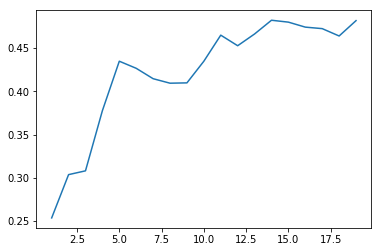

In [97]:
import matplotlib.pyplot as plt

plt.plot( range(1,20), result_cs_small)

## Question (c)


Based on the coherence score the topic number shoud be 14. 

In [136]:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= 14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= 14, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

## Question (a)

In [123]:

model_topics = lda_model.show_topics(formatted=False)
pprint(model_topics)

[(10,
  [('son', 0.0291217),
   ('taxi', 0.019202469),
   ('dan', 0.013070379),
   ('autre', 0.008533946),
   ('sont', 0.005241233),
   ('importante', 0.0047514075),
   ('cote', 0.003767327),
   ('avec', 0.003580918),
   ('entreprise', 0.0026165037),
   ('alor', 0.001877979)]),
 (6,
  [('dive', 0.016476545),
   ('museum', 0.013907351),
   ('occupy', 0.0087277545),
   ('diminish', 0.00599002),
   ('sensible', 0.003724688),
   ('rave', 0.0014168606),
   ('npopulation', 5.099797e-05),
   ('enthusiast', 5.0996892e-05),
   ('mountain', 5.099648e-05),
   ('nle', 5.0996052e-05)]),
 (2,
  [('notable', 0.03137151),
   ('fortnite', 0.020651022),
   ('unknown', 0.019940278),
   ('fantasy', 0.0069360607),
   ('reel', 0.0036456983),
   ('epic_game', 4.9265007e-05),
   ('football', 4.926113e-05),
   ('bundle', 4.9260758e-05),
   ('valve', 4.9260485e-05),
   ('amband', 4.9260478e-05)]),
 (11,
  [('suspect', 0.035401635),
   ('shoe', 0.03158911),
   ('arrest', 0.027133055),
   ('coverage', 0.021064453

# Quesyion (b)

In [150]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[0]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=content_list)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic["Document_No","Dominant_Topic", "Topic_Perc_Contrib","Text" ].head(10)

KeyError: ('Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Text')